# Artificial Neural Networks for Complete Intersection Calabi-Yau Manifold

In the framework of String Theory, we apply **deep learning** techniques for the prediction of the **Hodge numbers** of _Complete Intersection Calabi-Yau_ (CICY) 3-folds. The relevant quantities are therefore $h_{11}$ and $h_{21}$ which can be predicted starting from the configuration matrices of known manifolds.

We take advantage of previously studied and feature engineered datasets to build **deep neural networks** (DNN) and **convolutional neural networks** (CNN) to predict the labels. We use [Tensorflow](https://www.tensorflow.org/) as backend framework and its high level API [Keras](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras).

## Setup

We first setup the environment and import relevant packages which we will use in the analysis. We print their versions to keep track of changes and set the **random seed** of all random generators in order to get reproducible results.

In [1]:
import sys

import matplotlib        as mpl
import matplotlib.pyplot as plt
import random            as rnd
import numpy             as np
import pandas            as pd
import sklearn           as skl
import tensorflow        as tf

from tensorflow       import keras
from tensorflow.keras import backend as K

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # ignore UserWarning: I cannot really do anything about it...

print('Python version: {:d}.{:d}'      .format(sys.version_info.major, sys.version_info.minor), flush=True)
print('Matplot version: {}'            .format(mpl.__version__),                                flush=True)
print('Numpy version: {}'              .format(np.__version__),                                 flush=True)
print('Pandas version: {}'             .format(pd.__version__),                                 flush=True)
print('Scikit-learn version: {}'       .format(skl.__version__),                                flush=True)
print('Tensorflow version: {}'         .format(tf.__version__),                                 flush=True)
print('Keras version: {} (backend: {})'.format(keras.__version__, K.backend()),                 flush=True)

# fix random_seed
RAND = 42
rnd.seed(RAND)
np.random.seed(RAND)
tf.random.set_seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.1
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1
Tensorflow version: 2.0.0
Keras version: 2.2.4-tf (backend: tensorflow)


We also print the **hardware specifications** to have a representation of the current build.

In [2]:
!echo "OS:  $(uname -o) - $(lsb_release -d| sed 's/^.*:\s*//g')"
!echo "CPU: $(lscpu| grep 'Model name'| sed 's/^.*:\s*//g')"
!echo "RAM: $(free --giga| awk '/^Mem/ {print $7}') GiB"
!echo "GPU: $(lspci | grep '3D controller' | sed 's/^.*controller:\s*//g')"

OS:  GNU/Linux - Arch Linux
CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
RAM: 9 GiB
GPU: NVIDIA Corporation GM108M [GeForce 940MX] (rev a2)


In order to store information and results, we create a **logger** for the current Python session and a function to print information to the log file (or the standard output, if the logger is not defined).

In [3]:
import logging

from os import path, rename
from time import strftime, gmtime

def create_logfile(filename, name='logger', level=logging.INFO):
    """
    Create a logfile and rotate old logs.
    
    Required arguments:
        filename: the name of the file or path to the log
        
    Optional arguments
        name:     the name of the log session
        level:    the level of the information stores
        
    Returns:
        the log
    """
    
    # get current time to rename strings
    ctime = strftime('.%Y%m%d.%H%M%S', gmtime())
    
    # rotate log if it already exists
    if path.isfile(filename):
        print('Rotating existing logs...', flush=True)
        rename(filename, filename + ctime)
    
    # get a logging session by name
    log = logging.getLogger(name + ctime)
    log.setLevel(level)
    
    # define format
    fmt = logging.Formatter('%(asctime)s --> %(levelname)s: %(message)s')
    
    # add the log file
    han = logging.FileHandler(filename=filename)
    han.setLevel(level)
    han.setFormatter(fmt)
    
    # add handler for standard output
    std = logging.StreamHandler(sys.stdout)
    std.setLevel(level)
    std.setFormatter(fmt)
    
    # create the output
    log.addHandler(han)
    log.addHandler(std)
    
    print('Created new log file!', flush=True)
    return log

def logprint(string, stream='info', logger=None):
    """
    Decides whether to print on the logger or the standard output.
    
    Required arguments:
        string: the string to print
    
    Optional arguments:
        stream: standard input (info) or standard error (error)
        logger: the logger (None for standard output/error)
    """
    
    if logger is not None:
        if stream == 'info':
            logger.info(string)
        elif stream == 'error':
            logger.error(string)
        else:
            logger.debug(string)
    else:
        if stream == 'info':
            sys.stdout.write(string)
        elif stream == 'error':
            sys.stderr.write(string)
        else:
            sys.stdout.write(string)

## Preparation and Tools

We first fetch the desired dataset and prepare the tools for the analysis. Specifically we need to:

1. define the names of the main **directories** and create them if non existent,
2. import the **database** and read the archive,
3. create tools for **visualisation** and **manipulation** of the dataset.

In [4]:
import logging
from os import makedirs

ROOT_DIR = '.'      # root directory
IMG_DIR  = 'img'    # image directory
MOD_DIR  = 'models' # directory of saved models
LOG_DIR  = 'log'    # directory for logs

# name of the dataset to be considered
DB_NAME = 'cicy3o'
DB_FILE = DB_NAME + '.h5'                                     # full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE)                        # full path
DB_DIR  = 'original' if DB_NAME == 'cicy3o' else 'favourable' # subdir where to store images, models, logs

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR, DB_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR, DB_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR, DB_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)
    
# create logfile
logger = create_logfile(filename=path.join(LOG_PATH, DB_NAME + '_nn_transfer-learning.log'), name='CICY3', level=logging.INFO)

Rotating existing logs...
Created new log file!


We then prepare to load the dataset and prepare for the visualisation analysis.

In [5]:
import pandas as pd

def load_dataset(filepath, mode='hdf5', shuffle=False, random_state=None, logger=None):
    """
    Load a dataset given the path and the format.
    
    Required arguments:
        filepath: the path of the file
        
    Optional arguments:
        mode:         the format of the file
        shuffle:      whether to shuffle the file
        random_state: the seed of the random generator
        logger:       the logging session (None for standard output)
        
    Returns:
        the dataset
    """
    
    if path.isfile(filepath):
        logprint('Reading database...', logger=logger)
        if mode == 'hdf5':
            df = pd.read_hdf(filepath)
        elif mode == 'csv':
            df = pd.read_csv(filepath)
        logprint('Database loaded!', logger=logger)
    else:
        logprint('Database is not available: cannot load the database!', stream='error', logger=logger)
        
    # shuffle the dataframe
    if shuffle and random_state is not None:
        logprint('Shuffling database...', logger=logger)
        df = skl.utils.shuffle(df, random_state=random_state)
        logprint('Database shuffled!', logger=logger)
        
    return df

We then define some functions we can use to extract and manipulate the database. We use the _Scikit-learn_ API to create _Estimator_ classes (inheriting the _Scikit_ interface).

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# remove the outliers from a Pandas dataset
class RemoveOutliers(BaseEstimator, TransformerMixin):
    """
    Remove outlying data given a dataset and a dictionary containing the intervals for each class.
    
    E.g.: if the two classes are 'h11' and 'h21', the dictionary will be: {'h11': [1, 16], 'h21': [1, 86]}.
    
    Public methods:
        fit:           unused method
        transform:     remove data outside the given interval
        fit_transform: equivalent to transform(fit(...))
    """

    def __init__(self, filter_dict=None):
        """
        Constructor of the class.
        
        Optional arguments:
            filter_dict: the intervals to retain in the data
        """
        
        self.filter_dict = filter_dict

    def fit(self, X, y=None):
        """
        Unused method.
        """

        return self

    def transform(self, X):
        """
        Transform the input by deleting data outside the interval
        
        Required arguments:
            X: the dataset
            
        Returns:
            the transformed dataset
        """

        x = X.copy() # avoid overwriting

        if self.filter_dict is not None:
            for key in self.filter_dict:
                x = x.loc[x[key] >= self.filter_dict[key][0]]
                x = x.loc[x[key] <= self.filter_dict[key][1]]

        return x

# extract the tensors from a Pandas dataset
class ExtractTensor(BaseEstimator, TransformerMixin):
    """
    Extract a dense tensor from sparse input from a given dataset.
    
    Public methods:
        fit:           unused method
        transform:     extract dense tensor
        fit_transform: equivalent to transform(fit(...))
        get_shape:     compute the shape of the tensor
    """

    def __init__(self, flatten=False, shape=None):
        """
        Constructor of the class.
        
        Optional arguments:
            flatten: whether to flatten the output or keep the current shape
            shape:   force the computation with a given shape
        """

        self.flatten = flatten
        self.shape   = shape

    def fit(self, X, y=None):
        """
        Unused method.
        """

        return self

    def transform(self, X):
        """
        Compute the dense equivalent of the sparse input.
        
        Required arguments:
            X: the dataset
            
        Returns:
            the transformed input
        """

        x = X.copy() # avoid overwriting
        if self.shape is None:
            self.shape = x.apply(np.shape).max() # get the shape of the tensor

        if len(self.shape) > 0: # apply this to vectors and tensors
            offset = lambda s : [ (0, self.shape[i] - np.shape(s)[i]) for i in range(len(self.shape)) ]
            x      = x.apply(lambda s: np.pad(s, offset(s), mode='constant'))

        if self.flatten and len(self.shape) > 0:
            return list(np.stack(x.apply(np.ndarray.flatten).values))
        else:
            return list(np.stack(x.values))

    def get_shape(self):
        """
        Compute the shape of the tensor.
        
        Returns:
            the shape of the tensor
        """
        
        return self.shape

We the define the functions we will use to evaluate and improve the algorithms. Even though the ultimate goal is a regression task, we will however predict integer values $h_{11},~h_{21} \in \mathbb{Z}$, thus we will evaluate the **accuracy** of the prediction, given the best estimate (in general we use the _mean squared error_ to evaluate the algorithms, but we accept those with best _accuracy_).

In [7]:
# get the accuracy (possibly after rounding)
def accuracy_score(y_true, y_pred, rounding=np.rint):
    """
    Compute the accuracy of the predictions after rounding.
    
    Required arguments:
        y_true: true values
        y_pred: predicted values
        
    Optional arguments:
        rounding: the Numpy function for rounding the predictions
    """

    assert np.shape(y_true)[0] == np.shape(y_pred)[0] # check if same length
    
    # if same length then proceed
    accuracy = 0
    if rounding is not None:
        for n in range(np.shape(y_true)[0]):
            accuracy = accuracy + 1 \
                       if int(y_true[n]) == int(rounding(y_pred[n])) \
                       else accuracy
    else:
        for n in range(np.shape(y_true)[0]):
            accuracy = accuracy + 1 \
                       if y_true[n] == y_pred[n] \
                       else accuracy
    return accuracy / np.shape(y_true)[0]

# get the error difference (possibly after rounding)
def error_diff(y_true, y_pred, rounding=np.rint):
    """
    Compute the error difference between true values and predictions (positive values are overestimate and viceversa).
    
    Required arguments:
        y_true: true values
        y_pred: predicted values
        
    Optional arguments:
        rounding: the Numpy function for rounding the predictions
    """

    assert np.shape(y_true)[0] == np.shape(y_pred)[0] # check if same length

    # if same length then proceed
    err = y_true - rounding(y_pred)
    return np.array(err).astype(np.int16)

# print *SearchCV scores
def gridcv_score(estimator, rounding=np.rint, logger=None):
    """
    Print scores given by cross-validation and optimisation techniques.
    
    Required arguments:
        estimator: the estimator to be evaluated
        
    Optional arguments:
        rounding: the Numpy function for rounding the predictions
        logger:   the logging session (None for standard output)
    """
    
    best_params = estimator.best_params_              # get best parameters
    df          = pd.DataFrame(estimator.cv_results_) # dataframe with CV res.
    
    cv_best_res = df.loc[df['params'] == best_params] # get best results
    accuracy    = cv_best_res.loc[:, 'mean_test_score'].values[0]
    std         = cv_best_res.loc[:, 'std_test_score'].values[0]
    
    logprint('Best parameters: {}'.format(best_params), logger=logger)
    logprint('Accuracy ({}) of cross-validation: ({:.3f} ± {:.3f})%'.format(rounding.__name__, accuracy*100, std*100), logger=logger)
    
# print the accuracy of the predictions
def prediction_score(estimator, X, y, use_best_estimator=False, rounding=np.rint, logger=None):
    """
    Print the accuracy of the predictions.
    
    Required arguments:
        estimator: the estimator to be used for the predictions
        X: the features
        y: the labels (actual values)
        
    Optional arguments:
        use_best_estimator: whether to use the estimator.best_estimator_ or just estimator
        rounding: the Numpy function for rounding the predictions
        logger:   the logging session (None for standard output)
    """
    
    if use_best_estimator:
        estimator = estimator.best_estimator_
    
    accuracy = accuracy_score(y, estimator.predict(X), rounding=rounding)
    logprint('Accuracy ({}) of the predictions: {:.3f}%'.format(rounding.__name__, accuracy*100), logger=logger)

We use _Matplotlib_ to plot the data and define a few functions which we can use during the analysis:

In [8]:
# set label sizes
%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# set building block sizes for the plot
mpl_width  = 6
mpl_height = 5

# save the current figure
def save_fig(filename, tight_layout=True, extension='png', resolution=96, logger=None):
    """
    Save current figure to file.
    
    Required arguments:
        filename: the name of the file where to save the figure (without extension)
        
    Optional arguments:
        tight_layout: whether to use the tight_layout
        extension:    extension of the file to use
        resolution:   resolution of the file
        logger:       the logging session (None for standard output)
    """

    filename = path.join(IMG_PATH, filename + '.' + extension)
    if tight_layout:
        plt.tight_layout()

    logprint('Saving {}...'.format(filename), logger=logger)
    plt.savefig(filename, format=extension, dpi=resolution)
    logprint('Saved {}!'.format(filename), logger=logger)

# get a generator to count the occurrencies
def get_counts(df, label, feature):
    """
    Generator to produce the count of unique occurrencies of the data.
    
    Required arguments:
        df:      the Pandas dataframe
        label:   the label to consider
        feature: the feature to consider
        
    Yields:
        [ unique feature, unique value, counts ]
    """

    for n in np.sort(df[feature].unique()):
        uniques, counts = np.unique(df[label].loc[df[feature] == n].values, return_counts=True)
        for u, c in np.c_[uniques, counts]:
            yield [ n, u, c ]

# plot histogram of occurrencies
def count_plot(ax, data, title=None, xlabel=None, ylabel='N',
               legend=None, xlog=False, ylog=False, binstep=5,
               **kwargs):
    """
    Plot histogram of occurrencies (e.g.: frequency plot).
    
    Required arguments:
        ax:   the subplot ax where to plot data
        data: the data to plot
        
    Optional arguments:
        title:    the title of the plot
        xlabel:   the label of the x axis
        ylabel:   the label of the y axis
        legend:   the label for the legend in the plot
        xlog:     whether to use the log scale on the x axis
        ylog:     whether to use the log scale on the y axis
        binstep:  the distance between adjacent bins
        **kwargs: additional arguments to pass to plt.hist
    """

    min_tick = np.min(data) if np.min(data) > -100 else -100 # set a MIN cut
    max_tick = np.max(data) if np.max(data) < 100  else 100  # set a MAX cut

    ax.grid(alpha=0.2)                   # create a grid
    ax.set_title(title)                  # set title
    ax.set_xlabel(xlabel)                # set a label for the x axis
    ax.set_ylabel(ylabel)                # set a label for the y axis
    ax.set_xticks(np.arange(min_tick,    # set no. of ticks in the x axis
                            max_tick,
                            step=binstep
                           )
                 )

    if xlog:                             # use log scale in x axis if needed
        ax.set_xscale('log')
    if ylog:                             # use log scale in y axis if needed
        ax.set_yscale('log')

    ax.hist(data,                        # create histogram using 'step' funct.
            histtype='step',
            label=legend,
            **kwargs)

    if legend is not None:               # add legend
        ax.legend(loc='best')

    return ax

# plot labeled features and their values
def label_plot(ax, data, title=None, xlabel=None, ylabel='values',
               legend=None, xlog=False, ylog=False, binstep=1,
               **kwargs):
    """
    Plot values of labelled data (e.g.: variable ranking).
    
    Required arguments:
        ax:   the subplot ax where to plot data
        data: the data to plot
        
    Optional arguments:
        title:    the title of the plot
        xlabel:   the label of the x axis
        ylabel:   the label of the y axis
        legend:   the label for the legend in the plot
        xlog:     whether to use the log scale on the x axis
        ylog:     whether to use the log scale on the y axis
        binstep:  the distance between adjacent bins
        **kwargs: additional arguments to pass to plt.plot
    """

    labels      = [f[0] for f in data]   # labels vector
    importances = [f[1] for f in data]   # importances vector
    length      = len(labels)            # length of the labels vector
    
    ax.grid(alpha=0.2)                   # create a grid
    ax.set_title(title)                  # set title
    ax.set_xlabel(xlabel)                # set a label for the x axis
    ax.set_ylabel(ylabel)                # set a label for the x axis

    ax.set_xticks(np.arange(length,      # set no. of ticks in the x axis
                            step=binstep
                           )
                 )
    ax.set_xticklabels(labels,           # set name of labels of the x axis
                       ha='right',       # horizontal alignment
                       rotation=45       # rotation of the labels
                      )

    if xlog:                             # use log scale in x axis if needed
        ax.set_xscale('log')
    if ylog:                             # use log scale in y axis if needed
        ax.set_yscale('log')

    ax.plot(np.arange(length),           # plot data
            importances,
            label=legend,
            **kwargs)

    if legend is not None:               # add legend
        ax.legend(loc='best')

    return ax

# plot the correlation matrix of a Pandas dataframe
def mat_plot(ax, matrix, labels, label='correlation matrix', **kwargs):
    """
    Plot the correlation matrix of a given dataframe.
    
    Required arguments:
        ax:     the subplot ax where to plot data
        matrix: the matrix to plot
        labels: the labels to show with the matrix
        
    Optional arguments:
        label:    the label to use for the colour bar
        **kwargs: additional arguments to pass to plt.matshow
    """
    
    ax.set_xticks(np.arange(len(labels), # set ticks for x axis
                  step=1)
                 )
    ax.set_xticklabels([''] + labels,    # set the name of the ticks
                       rotation=90
                      )

    ax.set_yticks(np.arange(len(labels), # set ticks for y axis
                  step=1)
                 )
    ax.set_yticklabels([''] + labels)    # set the name of the ticks
                    
    matshow = ax.matshow(matrix,         # show the matrix
                         vmin=-1.0,
                         vmax=1.0,
                         **kwargs
                        )
                                
    cbar = ax.figure.colorbar(matshow,   # create the colour bar
                              ax=ax,
                              fraction=0.05,
                              pad=0.05
                             )
    cbar.ax.set_ylabel(label,            # show the colour bar
                       va='bottom',      # vertical alignment
                       rotation=-90)     # rotation of the label

    return ax

# plot a scatter plot with colours and sizes
def scatter_plot(ax, data, title=None, xlabel=None, ylabel=None,
                 legend=None, xlog=False, ylog=False,
                 colour=True, size=True, colour_label='N', size_leg=0,
                 **kwargs):
    """
    Scatter plot of occurrencies with colour and size codes.
    
    Required arguments:
        ax:   the subplot ax where to plot data
        data: the data to plot
        
    Optional arguments:
        title:        the title of the plot
        xlabel:       the label of the x axis
        ylabel:       the label of the y axis
        legend:       the label for the legend in the plot
        xlog:         whether to use the log scale on the x axis
        ylog:         whether to use the log scale on the y axis
        colour:       whether to use colour codes
        size:         whether to use entries of different size
        colour_label: label to use for the colour code
        size_leg:     length of the legend of the size code
        **kwargs:     additional arguments to pass to plt.scatter
    """

    ax.grid(alpha=0.2)                   # create  a grid
    ax.set_xlabel(xlabel)                # set labels for the x axis
    ax.set_ylabel(ylabel)                # set labels for the y axis
    ax.set_title(title)                  # set title

    if xlog:                             # use log scale in x axis if needed
        ax.set_xscale('log')
    if ylog:                             # use log scale in y axis if needed
        ax.set_yscale('log')

    if colour:                           # create the plot with size and colours
        if size:
            scat = ax.scatter(data[0], data[1], s=data[2], c=data[2], **kwargs)
        else:
            scat = ax.scatter(data[0], data[1], c=data[2], **kwargs)
        cbar = ax.figure.colorbar(scat, ax=ax)
        cbar.ax.set_ylabel(colour_label, rotation=-90, va='bottom')
    else:
        if size:
            scat = ax.scatter(data[0], data[1], s=data[2], **kwargs)
        else:
            scat = ax.scatter(data[0], data[1], **kwargs)

    scat.set_label(legend)               # set label of the plot
    if size_leg:                         # add the size legend if needed
        handles, labels = scat.legend_elements('sizes', num=size_leg)
        ax.legend(handles, labels, loc='lower center',
                  bbox_to_anchor=(0.5,-0.3), ncol=len(handles),
                  fontsize='medium', frameon=False)

    if legend:                           # show the legend
        ax.legend(loc='best')

    return ax

# plot a series with trivial x label
def series_plot(ax, data, title=None, xlabel='series', ylabel=None,
                legend=None, xlog=False, ylog=False,
                step=False, std=False,
                **kwargs):
    """
    Plot a series of data with ordered x axis (e.g.: epoch series).
    
    Required arguments:
        ax:   the subplot ax where to plot data
        data: the data to plot
        
    Optional arguments:
        title:    the title of the plot
        xlabel:   the label of the x axis
        ylabel:   the label of the y axis
        legend:   the label for the legend in the plot
        xlog:     whether to use the log scale on the x axis
        ylog:     whether to use the log scale on the y axis
        step:     whether to use a step function for the plot
        std:      highlight the strip of the standard deviation
        **kwargs: additional arguments to pass to plt.step or plot.plot
    """

    ax.grid(alpha=0.2)                   # create the grid
    ax.set_title(title)                  # set the title
    ax.set_xlabel(xlabel)                # set labels for the x axis
    ax.set_ylabel(ylabel)                # set labels for the y axis

    if xlog:                             # use log scale in the x axis if needed
        ax.set_xscale('log')
    if ylog:                             # use log scale in the y axis if needed
        ax.set_yscale('log')

    series = np.arange(len(data))        # create trivial x axis data
    if step:                             # create the plot
        ax.step(series, data, label=legend, **kwargs)
    else:
        ax.plot(series, data, label=legend, **kwargs)

    if std:                              # show coloured strip with std
        ax.fill_between(series,
                        data + np.std(data),
                        data - np.std(data),
                        alpha=0.2)

    if legend is not None:               # show the legend
        ax.legend(loc='best')

    return ax

Before going further we also set the **memory growth** of the GPU RAM in order to avoid memory issues:

In [9]:
# get the list of installed GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) # set memory growth
            
        # get the list of logical devices (GPUs)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        logprint('GPU setup: {:d} physical GPUs, {:d} logical GPUs.'.format(len(gpus), len(logical_gpus)), logger=logger)
    except RuntimeError as e:
        logprint(e, stream='error', logger=logger)
else:
    logprint('No GPUs in the setup!', stream='error', logger=logger)

2020-04-21 13:59:01,273 --> INFO: GPU setup: 1 physical GPUs, 1 logical GPUs.


## Neural Networks

We then proceed with the analysis by first loading the prepared datasets and then building the appropriate architectures for the prediction of the Hodge numbers. We start from the analysis of the configuration matrix through a **CNN** architecture and then compare the results with the analysis of the engineered dataset.

We consider only the configuration matrix and build a CNN to predict the labels. First of all we load the dataset and then divide labels and features, we then proceed with the architecture of the CNN.

In [10]:
if path.isfile(path.join(ROOT_DIR, DB_NAME + '_matrix.h5')):
    matrix = load_dataset(path.join(ROOT_DIR, DB_NAME + '_matrix.h5'), logger=logger)
    h11    = np.array(ExtractTensor(flatten=False).fit_transform(matrix['h11']))
    h21    = np.array(ExtractTensor(flatten=False).fit_transform(matrix['h21']))
    matrix = np.array(ExtractTensor(flatten=False).fit_transform(matrix['matrix']))
    
if path.isfile(path.join(ROOT_DIR, DB_NAME + '_eng.h5')):
    feats      = load_dataset(path.join(ROOT_DIR, DB_NAME + '_eng.h5'), logger=logger)
    num_cp     = np.array(ExtractTensor(flatten=False).fit_transform(feats['num_cp']))
    dim_cp     = np.array(ExtractTensor(flatten=False).fit_transform(feats['dim_cp']))
    dim_h0_amb = np.array(ExtractTensor(flatten=False).fit_transform(feats['dim_h0_amb']))

2020-04-21 13:59:01,280 --> INFO: Reading database...
2020-04-21 13:59:01,402 --> INFO: Database loaded!
2020-04-21 13:59:01,905 --> INFO: Reading database...
2020-04-21 13:59:01,971 --> INFO: Database loaded!


## Setup and Preparation of the Input

We now split the set into training and test set. As for the ML analysis, we keep 10% of the whole set as **test set** and use the remaining 90% as **training set**. We then retain $\frac{1}{9}$ of the latter as **holdout validation set**, thus ending up using 10% of the whole set as validation and 80% as training.

In [11]:
from sklearn.model_selection import train_test_split

logprint('Splitting into training and test sets...', logger=logger)
matrix_train, matrix_test, \
num_cp_train, num_cp_test, \
dim_cp_train, dim_cp_test, \
dim_h0_amb_train, dim_h0_amb_test, \
h11_train, h11_test, \
h21_train, h21_test = train_test_split(matrix,
                                       num_cp,
                                       dim_cp,
                                       dim_h0_amb,
                                       h11,
                                       h21,
                                       test_size=0.1,
                                       shuffle=False)
logprint('Divided into training and test sets!', logger=logger)

2020-04-21 13:59:02,509 --> INFO: Splitting into training and test sets...
2020-04-21 13:59:02,520 --> INFO: Divided into training and test sets!


## Feature Rescaling

We then rescale and visualise the input in order to better understand what kind of network we should build. We cannot however use the _Scikit_ `StandardScaler` on the matrix since it would treat each entry of the matrix as independent inside the same matrix, but related amongst the matrices. We therefore look for the maximum mean and max entry inside the whole database and then manually apply the rescaling. We then apply the same procedure to the other features.

In [12]:
# compute mean and max for the matrix
id_mat_max_entry = np.unravel_index(np.argmax(matrix_train, axis=None), matrix_train.shape)
mat_max_entry    = matrix_train[id_mat_max_entry]
mat_mean         = np.mean(matrix_train)

# the entries are now in the interval [-1, 1]
matrix_train     = (matrix_train - mat_mean) / mat_max_entry
matrix_test      = (matrix_test  - mat_mean) / mat_max_entry

# compute mean and max for num_cp
id_num_cp_max_entry = np.unravel_index(np.argmax(num_cp, axis=None), num_cp.shape)
num_cp_max_entry    = num_cp[id_num_cp_max_entry]
num_cp_mean         = np.mean(num_cp_train)

# the entries are now in the interval [-1, 1]
num_cp_train     = (num_cp_train - num_cp_mean) / num_cp_max_entry
num_cp_test      = (num_cp_test  - num_cp_mean) / num_cp_max_entry

# compute mean and max for dim_cp
id_dim_cp_max_entry = np.unravel_index(np.argmax(dim_cp, axis=None), dim_cp.shape)
dim_cp_max_entry    = dim_cp[id_dim_cp_max_entry]
dim_cp_mean         = np.mean(dim_cp_train)

# the entries are now in the interval [-1, 1]
dim_cp_train     = (dim_cp_train - dim_cp_mean) / dim_cp_max_entry
dim_cp_test      = (dim_cp_test  - dim_cp_mean) / dim_cp_max_entry

# compute mean and max for dim_h0_amb
id_dim_h0_amb_max_entry = np.unravel_index(np.argmax(dim_h0_amb, axis=None), dim_h0_amb.shape)
dim_h0_amb_max_entry    = dim_h0_amb[id_dim_h0_amb_max_entry]
dim_h0_amb_mean         = np.mean(dim_h0_amb_train)

# the entries are now in the interval [-1, 1]
dim_h0_amb_train     = (dim_h0_amb_train - dim_h0_amb_mean) / dim_h0_amb_max_entry
dim_h0_amb_test      = (dim_h0_amb_test  - dim_h0_amb_mean) / dim_h0_amb_max_entry

# now we can divide the training set into training + validation
logprint('Splitting into training and validation sets...', logger=logger)
matrix_train, matrix_val, \
num_cp_train, num_cp_val, \
dim_cp_train, dim_cp_val, \
dim_h0_amb_train, dim_h0_amb_val, \
h11_train, h11_val, \
h21_train, h21_val  = train_test_split(matrix_train,
                                       num_cp_train,
                                       dim_cp_train,
                                       dim_h0_amb_train,
                                       h11_train,
                                       h21_train,
                                       test_size=1.0/9.0,
                                       shuffle=False)
logprint('Divided into training and validation sets!', logger=logger)

2020-04-21 13:59:02,559 --> INFO: Splitting into training and validation sets...
2020-04-21 13:59:02,564 --> INFO: Divided into training and validation sets!


We then get the input size of the tensor to insert in the model:

In [13]:
mat_input_shape = matrix.shape[1:]
num_cp_input_shape = (1,)
dim_cp_input_shape = dim_cp.shape[1:]
dim_h0_amb_input_shape = dim_h0_amb.shape[1:]

## Reshaping the Input

In order to use the 2D **convolutional layers**, we need to reshape the input such that it will be seen as a _black and white image_ (one filter as depth) of shape _rows x columns_.

In [14]:
logprint('Reshaping the input...', logger=logger)
matrix_train = matrix_train.reshape(-1, mat_input_shape[0], mat_input_shape[1], 1)
matrix_val   = matrix_val.  reshape(-1, mat_input_shape[0], mat_input_shape[1], 1)
matrix_test  = matrix_test. reshape(-1, mat_input_shape[0], mat_input_shape[1], 1)
logprint('Input reshaped!', logger=logger)

2020-04-21 13:59:02,583 --> INFO: Reshaping the input...
2020-04-21 13:59:02,586 --> INFO: Input reshaped!


## Model Building

We the build the architecture of the CNN. In this section we use **transfer learning** from the networks previously trained on the configuration matrix to predict $h_{11}$ and $h_{21}$. We then add other inputs to the matrices in order to improve the predictions.

In [15]:
from tensorflow.keras              import Input
from tensorflow.keras.utils        import plot_model
from tensorflow.keras.models       import Model, load_model
from tensorflow.keras.layers       import Conv1D, Conv2D, Dense, Lambda, Flatten, BatchNormalization, Dropout, LeakyReLU, concatenate, Activation
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks    import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def cnn_full_model(h11_model_path,
                   h21_model_path,
                   num_cp_shape,
                   dim_cp_shape,
                   dim_h0_amb_shape,
                   num_cp_neurons_h11=[30],
                   num_cp_neurons_h21=[30],
                   dim_cp_neurons_h11=[30],
                   dim_cp_neurons_h21=[30],
                   dim_h0_amb_neurons_h11=[30],
                   dim_h0_amb_neurons_h21=[30],
                   learning_rate=0.01,
                   batch_norm_momentum=0.99,
                   dropout_rate=0.3,
                   leaky_alpha=0.3,
                   l1_reg=0.0,
                   l2_reg=0.0,
                   last_relu=False,
                   last_layer_h11=1,
                   last_layer_h21=1
                  ):
    """
    Build a convolutional neural network with given parameters.
    
    Required arguments:
        h11_model_path:         the path of the CNN model to predict h11
        h21_model_path:         the path of the CNN model to predict h21
        num_cp_shape:           the shape of the tensor for num_cp
        dim_cp_shape:           the shape of the tensor for dim_cp
        dim_h0_amb_shape:       the shape of the tensor for dim_h0_amb
        
    Optional arguments:
        learning_rate:          the learning rate of SGD (Adam optimizer)
        num_cp_neurons_h11:     the list of units in each layer of the network for num_cp (for h11)
        num_cp_neurons_h21:     the list of units in each layer of the network for num_cp (for h21)
        dim_cp_neurons_h11:     the list of units in each layer of the network for dim_cp (for h11)
        dim_cp_neurons_h21:     the list of units in each layer of the network for dim_cp (for h21)
        dim_h0_amb_neurons_h11: the list of units in each layer of the network for dim_h0_amb (for h11)
        dim_h0_amb_neurons_h21: the list of units in each layer of the network for dim_h0_amb (for h21)
        batch_norm_momentum:    the momentum of the batch normalization
        dropout_rate:           the rate of the dropout in percentage
        leaky_alpha:            the slope of the LeakyReLU activation function
        l1_reg:                 the l1 regularization
        l2_reg:                 the l2 regularization
        last_relu:              whether to add ReLU activation function on the output layer
        last_layer_h11:         the no. of layers to insert between the concatenation of layers and the output node for h11
        last_layer_h21:         the no. of layers to insert between the concatenation of layers and the output node for h22
        
    Returns:
        the compiled model
    """
    # regularization
    regularization = l1_l2(l1=l1_reg, l2=l2_reg)
    
    # import the pretrained models
    if path.isfile(h11_model_path):
        logprint('Loading h11 model...', logger=logger)
        h11_model = load_model(h11_model_path)
        logprint('h11 model loaded!', logger=logger)
    else:
        logprint('Cannot load h11 model!', logger=logger)

    if path.isfile(h21_model_path):
        logprint('Loading h21 model...', logger=logger)
        h21_model = load_model(h21_model_path)
        logprint('h21 model loaded!', logger=logger)
    else:
        logprint('Cannot load h11 model!', logger=logger)
        
    # freeze the layers in the pre-trained models
    for n in range(len(h11_model.layers)):
        h11_model.layers[n].trainable = False
    for n in range(len(h21_model.layers)):
        h21_model.layers[n].trainable = False
        
    # then build the network for num_cp
    num_cp_in  = Input(shape=num_cp_shape, name='num_cp_input')
    num_cp_h11 = Lambda(lambda z: z, name='lambda_num_cp_h11')(num_cp_in)
    num_cp_h21 = Lambda(lambda z: z, name='lambda_num_cp_h21')(num_cp_in)
    
    for n_layer in range(len(num_cp_neurons_h11)):
        num_cp_h11 = Dense(units=num_cp_neurons_h11[n_layer],
                           kernel_regularizer=regularization,
                           name='num_cp_h11_{:d}'.format(n_layer)
                          )(num_cp_h11)
        num_cp_h11 = LeakyReLU(alpha=leaky_alpha,
                               name='num_cp_h11_activation_{:d}'.format(n_layer)
                              )(num_cp_h11)
        
        if batch_norm_momentum > 0.0:
            num_cp_h11 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='num_cp_h11_batch_norm_{:d}'.format(n_layer)
                                           )(num_cp_h11)
    
    for n_layer in range(len(num_cp_neurons_h21)):
        num_cp_h21 = Dense(units=num_cp_neurons_h21[n_layer],
                           kernel_regularizer=regularization,
                           name='num_cp_h21_{:d}'.format(n_layer)
                          )(num_cp_h21)
        num_cp_h21 = LeakyReLU(alpha=leaky_alpha,
                               name='num_cp_h21_activation_{:d}'.format(n_layer)
                              )(num_cp_h21)
        
        if batch_norm_momentum > 0.0:
            num_cp_h21 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='num_cp_h21_batch_norm_{:d}'.format(n_layer)
                                           )(num_cp_h21)
    
    if dropout_rate > 0.0:
        num_cp_h11 = Dropout(rate=dropout_rate, name='num_cp_h11_dropout')(num_cp_h11)
        num_cp_h21 = Dropout(rate=dropout_rate, name='num_cp_h21_dropout')(num_cp_h21)
        
    # then build the network for dim_cp
    dim_cp_in  = Input(shape=dim_cp_shape, name='dim_cp_input')
    dim_cp_h11 = Lambda(lambda z: z, name='lambda_dim_cp_h11')(dim_cp_in)
    dim_cp_h21 = Lambda(lambda z: z, name='lambda_dim_cp_h21')(dim_cp_in)
    
    for n_layer in range(len(dim_cp_neurons_h11)):
        dim_cp_h11 = Dense(units=dim_cp_neurons_h11[n_layer],
                           kernel_regularizer=regularization,
                           name='dim_cp_h11_{:d}'.format(n_layer)
                          )(dim_cp_h11)
        dim_cp_h11 = LeakyReLU(alpha=leaky_alpha,
                               name='dim_cp_h11_activation_{:d}'.format(n_layer)
                              )(dim_cp_h11)
        
        if batch_norm_momentum > 0.0:
            dim_cp_h11 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='dim_cp_h11_batch_norm_{:d}'.format(n_layer)
                                           )(dim_cp_h11)
    
    for n_layer in range(len(dim_cp_neurons_h21)):
        dim_cp_h21 = Dense(units=dim_cp_neurons_h21[n_layer],
                           kernel_regularizer=regularization,
                           name='dim_cp_h21_{:d}'.format(n_layer)
                          )(dim_cp_h21)
        dim_cp_h21 = LeakyReLU(alpha=leaky_alpha,
                               name='dim_cp_h21_activation_{:d}'.format(n_layer)
                              )(dim_cp_h21)
        
        if batch_norm_momentum > 0.0:
            dim_cp_h21 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='dim_cp_h21_batch_norm_{:d}'.format(n_layer)
                                           )(dim_cp_h21)
    
    if dropout_rate > 0.0:
        dim_cp_h11 = Dropout(rate=dropout_rate, name='dim_cp_h11_dropout')(dim_cp_h11)
        dim_cp_h21 = Dropout(rate=dropout_rate, name='dim_cp_h21_dropout')(dim_cp_h21)
        
    # then build the network for dim_h0_amb
    dim_h0_amb_in  = Input(shape=dim_h0_amb_shape, name='dim_h0_amb_input')
    dim_h0_amb_h11 = Lambda(lambda z: z, name='lambda_dim_h0_amb_h11')(dim_h0_amb_in)
    dim_h0_amb_h21 = Lambda(lambda z: z, name='lambda_dim_h0_amb_h21')(dim_h0_amb_in)
    
    for n_layer in range(len(dim_h0_amb_neurons_h11)):
        dim_h0_amb_h11 = Dense(units=dim_h0_amb_neurons_h11[n_layer],
                           kernel_regularizer=regularization,
                           name='dim_h0_amb_h11_{:d}'.format(n_layer)
                          )(dim_h0_amb_h11)
        dim_h0_amb_h11 = LeakyReLU(alpha=leaky_alpha,
                               name='dim_h0_amb_h11_activation_{:d}'.format(n_layer)
                              )(dim_h0_amb_h11)
        
        if batch_norm_momentum > 0.0:
            dim_h0_amb_h11 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='dim_h0_amb_h11_batch_norm_{:d}'.format(n_layer)
                                           )(dim_h0_amb_h11)
    
    for n_layer in range(len(dim_h0_amb_neurons_h21)):
        dim_h0_amb_h21 = Dense(units=dim_h0_amb_neurons_h21[n_layer],
                           kernel_regularizer=regularization,
                           name='dim_h0_amb_h21_{:d}'.format(n_layer)
                          )(dim_h0_amb_h21)
        dim_h0_amb_h21 = LeakyReLU(alpha=leaky_alpha,
                               name='dim_h0_amb_h21_activation_{:d}'.format(n_layer)
                              )(dim_h0_amb_h21)
        
        if batch_norm_momentum > 0.0:
            dim_h0_amb_h21 = BatchNormalization(momentum=batch_norm_momentum,
                                            name='dim_h0_amb_h21_batch_norm_{:d}'.format(n_layer)
                                           )(dim_h0_amb_h21)
    
    if dropout_rate > 0.0:
        dim_h0_amb_h11 = Dropout(rate=dropout_rate, name='dim_h0_amb_h11_dropout')(dim_h0_amb_h11)
        dim_h0_amb_h21 = Dropout(rate=dropout_rate, name='dim_h0_amb_h21_dropout')(dim_h0_amb_h21)
      
    # concatenate the outputs
    h11_transfer_learning = concatenate([h11_model.output,
                                         num_cp_h11,
                                         dim_cp_h11,
                                         dim_h0_amb_h11],
                                        name='h11_concatenate'
                                       )
    for n in range(last_layer_h11):
        h11_transfer_learning = Dense(units=h11_transfer_learning.shape[1],
                                      name='h11_concatenate_dense_{:d}'.format(n)
                                     )(h11_transfer_learning)
        h11_transfer_learning = LeakyReLU(alpha=leaky_alpha,
                                          name='h11_concatenate_dense_activation_{:d}'.format(n)
                                         )(h11_transfer_learning)
    
    # improve the result of the matrix with the processed output
    h11_transfer_learning = Dense(units=1, name='h11_improvements')(h11_transfer_learning)
    h11_transfer_learning = LeakyReLU(alpha=leaky_alpha, name='h11_improvements_activation')(h11_transfer_learning)
    h11_transfer_learning = concatenate([h11_transfer_learning, h11_model.output])
    h11_transfer_learning = Dense(units=1,
                                  activation='relu',
                                  name='h11'
                                 )(h11_transfer_learning) if last_relu \
                                                          else Dense(units=1,
                                                                     name='h11'
                                                                    )(h11_transfer_learning)
    
    h21_transfer_learning = concatenate([h21_model.output,
                                         h11_model.output,
                                         num_cp_h21,
                                         dim_cp_h21,
                                         dim_h0_amb_h21],
                                        name='h21_concatenate'
                                       )
    for n in range(last_layer_h21):
        h21_transfer_learning = Dense(units=h21_transfer_learning.shape[1],
                                      name='h21_concatenate_dense_{:d}'.format(n)
                                     )(h21_transfer_learning)
        h21_transfer_learning = LeakyReLU(alpha=leaky_alpha,
                                          name='h21_concatenate_dense_activation_{:d}'.format(n)
                                         )(h21_transfer_learning)
        
    # improve the result of the matrix with the processed output
    h21_transfer_learning = Dense(units=1, activation='relu', name='h21_improvements')(h21_transfer_learning)
    h21_transfer_learning = LeakyReLU(alpha=leaky_alpha, name='h21_improvements_activation')(h21_transfer_learning)
    h21_transfer_learning = concatenate([h21_transfer_learning, h21_model.output])
    h21_transfer_learning = Dense(units=1,
                                  activation='relu',
                                  name='h21'
                                 )(h21_transfer_learning) if last_relu \
                                                          else Dense(units=1,
                                                                     name='h21'
                                                                    )(h21_transfer_learning)
    # compile the model
    model = Model(inputs=[h11_model.input, h21_model.input, num_cp_in, dim_cp_in, dim_h0_amb_in],
                  outputs=[h11_transfer_learning, h21_transfer_learning]
                 )
    model.compile(optimizers=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model

We then visualise the model:

2020-04-21 13:59:02,814 --> INFO: Building the full convolutional model...
2020-04-21 13:59:02,817 --> INFO: Loading h11 model...
2020-04-21 13:59:06,258 --> INFO: h11 model loaded!
2020-04-21 13:59:06,259 --> INFO: Loading h21 model...
2020-04-21 13:59:10,753 --> INFO: h21 model loaded!
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 12, 15, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 12, 15, 1)    4           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 12, 15, 180)  6660        batch_normalization_23[0][0]     
___

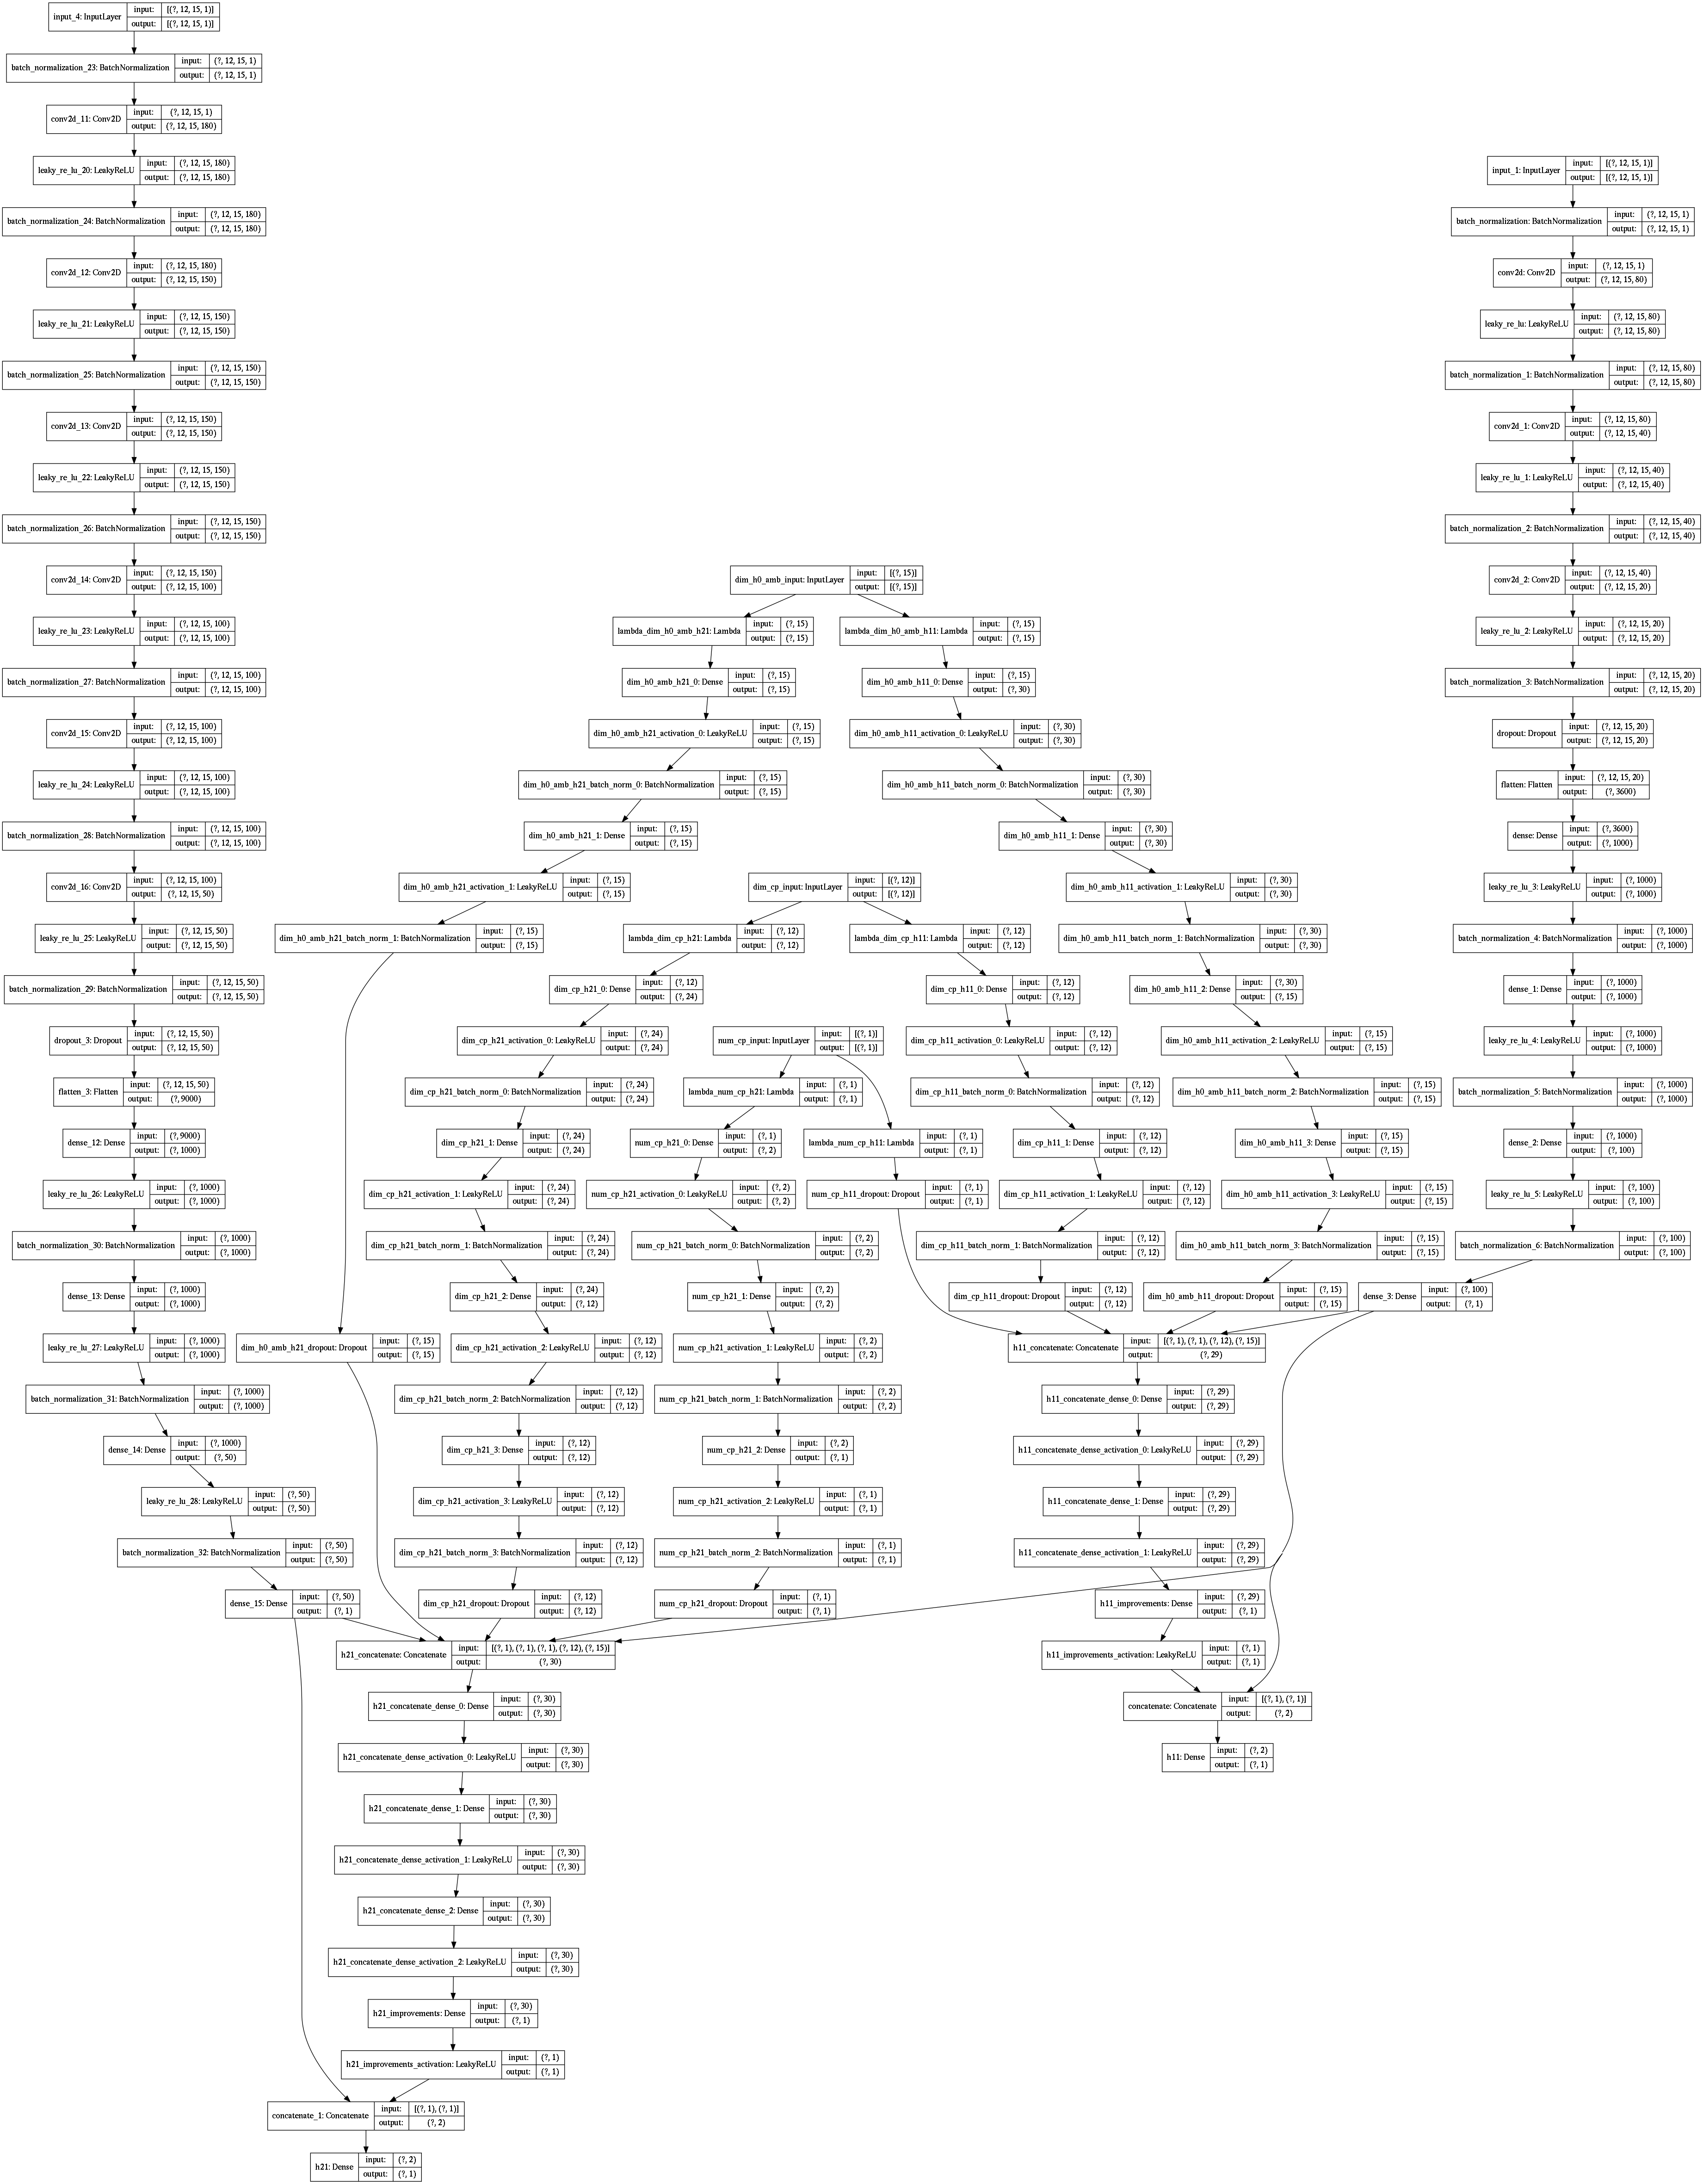

In [16]:
h11_model_path = path.join(MOD_PATH, 'cnn_model_matrix_h11.h5')
h21_model_path = path.join(MOD_PATH, 'cnn_model_matrix_h21.h5')

logprint('Building the full convolutional model...', logger=logger)
model = cnn_full_model(h11_model_path=h11_model_path,
                       h21_model_path=h21_model_path,
                       num_cp_shape=num_cp_input_shape,
                       dim_cp_shape=dim_cp_input_shape,
                       dim_h0_amb_shape=dim_h0_amb_input_shape,
                       num_cp_neurons_h11=[],
                       num_cp_neurons_h21=[2, 2, 1],
                       dim_cp_neurons_h11=[12, 12],
                       dim_cp_neurons_h21=[24, 24, 12, 12],
                       dim_h0_amb_neurons_h11=[30, 30, 15, 15],
                       dim_h0_amb_neurons_h21=[15, 15],
                       learning_rate=0.03,
                       batch_norm_momentum=0.99,
                       dropout_rate=0.3,
                       leaky_alpha=0.1,
                       l1_reg=1.0e-5,
                       l2_reg=1.0e-4,
                       last_relu=True,
                       last_layer_h11=2,
                       last_layer_h21=3
                      )

model.summary()
plot_model(model=model,
           to_file=path.join(IMG_PATH, 'cnn_full_model.png'),
           show_shapes=True
          )

And finally we fit the model. We have two options: the first is to monitor the **validation loss** to measure the stability of the algorithm and choose the best training epoch and the second is to separately monitor the **MSE** on $h_{11}$ and $h_{21}$ and separately produce predictions for the Hodge numbers. After many trials with the first option, we decide to use the second method (even though it takes longer) because we want to get the best possible predictions in a consistent way.

In [17]:
# define the callbacks (NB: with restore_best_weights we do not need to reload the model for evaluation)
callbacks_h11=[EarlyStopping(monitor='val_h11_mean_squared_error', patience=50, verbose=1, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_h11_mean_squared_error', factor=0.33, patience=20, verbose=1),
               ModelCheckpoint(monitor='val_h11_mean_squared_error', filepath=path.join(MOD_PATH, 'cnn_full_model_h11.h5'), verbose=1, save_best_only=True)
              ]

# fit the model
logprint('Training the full model with the h11 objectives...', logger=logger)
model_hst_h11 = model.fit(x=[matrix_train, matrix_train, num_cp_train, dim_cp_train, dim_h0_amb_train],
                          y=[h11_train, h21_train],
                          batch_size=256,
                          epochs=1000,
                          verbose=1,
                          callbacks=callbacks_h11,
                          validation_data=([matrix_val, matrix_val, num_cp_val, dim_cp_val, dim_h0_amb_val], [h11_val, h21_val])
                         )

2020-04-21 13:59:13,277 --> INFO: Training the full model with the h11 objectives...
Train on 6280 samples, validate on 785 samples
Epoch 1/1000
6144/6280 [============================>.] - ETA: 0s - loss: 9.1538 - h11_loss: 0.7800 - h21_loss: 8.0867 - h11_mean_squared_error: 0.7800 - h21_mean_squared_error: 8.0867
Epoch 00001: val_h11_mean_squared_error improved from inf to 0.57788, saving model to ./models/original/cnn_full_model_h11.h5
6280/6280 [==============================] - 32s 5ms/sample - loss: 8.9753 - h11_loss: 0.7534 - h21_loss: 7.7837 - h11_mean_squared_error: 0.7656 - h21_mean_squared_error: 7.9226 - val_loss: 3.7921 - val_h11_loss: 0.5118 - val_h21_loss: 2.5456 - val_h11_mean_squared_error: 0.5779 - val_h21_mean_squared_error: 2.9272
Epoch 2/1000
6144/6280 [============================>.] - ETA: 0s - loss: 4.3069 - h11_loss: 0.3993 - h21_loss: 3.6206 - h11_mean_squared_error: 0.3993 - h21_mean_squared_error: 3.6206
Epoch 00002: val_h11_mean_squared_error improved from 

We then evaluate the model with the $h_{11}$ objectives:

2020-04-21 14:18:19,975 --> INFO: Evaluating the full model with the h11 objectives...
2020-04-21 14:18:22,843 --> INFO: Evaluation for h11 --> Loss: 0.223, MSE: 0.227
2020-04-21 14:18:22,844 --> INFO: Evaluation for h21 --> Loss: 3.372, MSE: 3.371
2020-04-21 14:18:25,504 --> INFO: Accuracy for h11 on the validation set: 92.229%
2020-04-21 14:18:25,505 --> INFO: Accuracy for h21 on the validation set: 31.847%
2020-04-21 14:18:27,220 --> INFO: Accuracy for h11 on the test set: 90.712%
2020-04-21 14:18:27,221 --> INFO: Accuracy for h21 on the test set: 27.863%
2020-04-21 14:18:27,408 --> INFO: Saving ./img/original/cnn_full_model_learning_curve_h11.png...
2020-04-21 14:18:27,592 --> INFO: Saved ./img/original/cnn_full_model_learning_curve_h11.png!


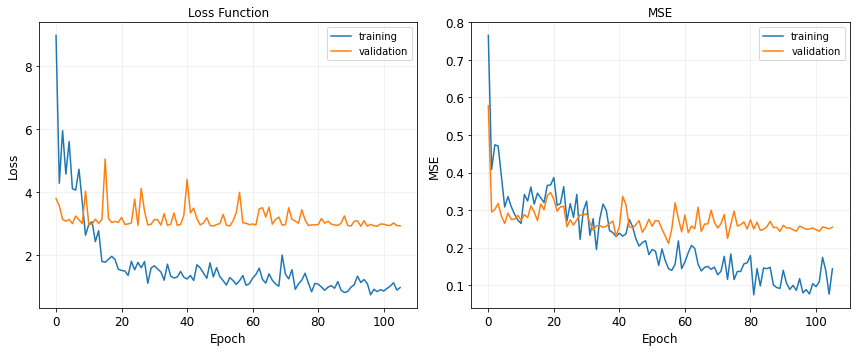

In [18]:
# evaluate the model
logprint('Evaluating the full model with the h11 objectives...', logger=logger)
model_ev = model.evaluate(x=[matrix_test, matrix_test, num_cp_test, dim_cp_test, dim_h0_amb_test], y=[h11_test, h21_test], verbose=0)
logprint('Evaluation for h11 --> Loss: {:.3f}, MSE: {:.3f}'.format(model_ev[1], model_ev[3]), logger=logger)
logprint('Evaluation for h21 --> Loss: {:.3f}, MSE: {:.3f}'.format(model_ev[2], model_ev[4]), logger=logger)

# accuracy of the model
predictions_val  = model.predict(x=[matrix_val, matrix_val, num_cp_val, dim_cp_val, dim_h0_amb_val])
logprint('Accuracy for h11 on the validation set: {:.3f}%'.format(accuracy_score(h11_val, predictions_val[0], rounding=np.rint)*100.0), logger=logger)
logprint('Accuracy for h21 on the validation set: {:.3f}%'.format(accuracy_score(h21_val, predictions_val[1], rounding=np.rint)*100.0), logger=logger)
predictions_test = model.predict(x=[matrix_test, matrix_test, num_cp_test, dim_cp_test, dim_h0_amb_test])
logprint('Accuracy for h11 on the test set: {:.3f}%'.format(accuracy_score(h11_test, predictions_test[0], rounding=np.rint)*100.0), logger=logger)
logprint('Accuracy for h21 on the test set: {:.3f}%'.format(accuracy_score(h21_test, predictions_test[1], rounding=np.rint)*100.0), logger=logger)

# loss function
model_history = model_hst_h11.history

xplots  = 2
yplots  = 1

fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

series_plot(ax[0], model_history['loss'],                       title='Loss Function', xlabel='Epoch', ylabel='Loss', legend='training')
series_plot(ax[0], model_history['val_loss'],                   title='Loss Function', xlabel='Epoch', ylabel='Loss', legend='validation')
series_plot(ax[1], model_history['h11_mean_squared_error'],     title='MSE',           xlabel='Epoch', ylabel='MSE',  legend='training')
series_plot(ax[1], model_history['val_h11_mean_squared_error'], title='MSE',           xlabel='Epoch', ylabel='MSE',  legend='validation')

save_fig('cnn_full_model_learning_curve_h11', logger=logger)

plt.show()
plt.close(fig)

We then keep training to find the best $h_{21}$ result:

In [19]:
# define the callbacks (NB: with restore_best_weights we do not need to reload the model for evaluation)
callbacks_h21=[EarlyStopping(monitor='val_h21_mean_squared_error', patience=50, verbose=1, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_h21_mean_squared_error', factor=0.33, patience=20, verbose=1),
               ModelCheckpoint(monitor='val_h21_mean_squared_error', filepath=path.join(MOD_PATH, 'cnn_full_model_h21.h5'), verbose=1, save_best_only=True)
              ]

# fit the model
logprint('Training the full model with the h21 objectives...', logger=logger)
model_hst_h21 = model.fit(x=[matrix_train, matrix_train, num_cp_train, dim_cp_train, dim_h0_amb_train],
                          y=[h11_train, h21_train],
                          batch_size=256,
                          epochs=1000,
                          verbose=1,
                          callbacks=callbacks_h21,
                          validation_data=([matrix_val, matrix_val, num_cp_val, dim_cp_val, dim_h0_amb_val], [h11_val, h21_val])
                         )

2020-04-21 14:18:27,800 --> INFO: Training the full model with the h21 objectives...
Train on 6280 samples, validate on 785 samples
Epoch 1/1000
6144/6280 [============================>.] - ETA: 0s - loss: 1.4976 - h11_loss: 0.1787 - h21_loss: 1.0346 - h11_mean_squared_error: 0.1787 - h21_mean_squared_error: 1.0346
Epoch 00001: val_h21_mean_squared_error improved from inf to 2.58827, saving model to ./models/original/cnn_full_model_h21.h5
6280/6280 [==============================] - 11s 2ms/sample - loss: 1.4745 - h11_loss: 0.1728 - h21_loss: 0.9977 - h11_mean_squared_error: 0.1755 - h21_mean_squared_error: 1.0146 - val_loss: 3.0963 - val_h11_loss: 0.1763 - val_h21_loss: 2.3293 - val_h11_mean_squared_error: 0.2237 - val_h21_mean_squared_error: 2.5883
Epoch 2/1000
6144/6280 [============================>.] - ETA: 0s - loss: 1.0651 - h11_loss: 0.1341 - h21_loss: 0.6467 - h11_mean_squared_error: 0.1341 - h21_mean_squared_error: 0.6467
Epoch 00002: val_h21_mean_squared_error improved from 

We then evaluate the model with the $h_{11}$ objectives:

2020-04-21 14:27:57,873 --> INFO: Evaluating the full model with the h21 objectives...
2020-04-21 14:27:59,849 --> INFO: Evaluation for h11 --> Loss: 0.254, MSE: 0.258
2020-04-21 14:27:59,850 --> INFO: Evaluation for h21 --> Loss: 2.895, MSE: 2.905
2020-04-21 14:28:01,568 --> INFO: Accuracy for h11 on the validation set: 91.083%
2020-04-21 14:28:01,570 --> INFO: Accuracy for h21 on the validation set: 37.962%
2020-04-21 14:28:03,270 --> INFO: Accuracy for h11 on the test set: 90.331%
2020-04-21 14:28:03,272 --> INFO: Accuracy for h21 on the test set: 34.478%
2020-04-21 14:28:03,406 --> INFO: Saving ./img/original/cnn_full_model_learning_curve_h21.png...
2020-04-21 14:28:03,598 --> INFO: Saved ./img/original/cnn_full_model_learning_curve_h21.png!


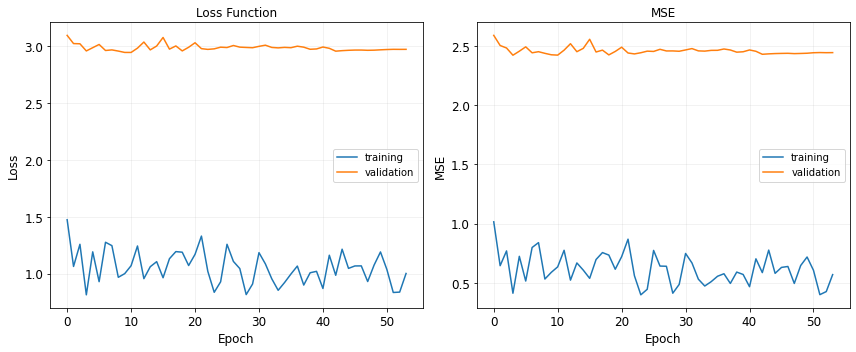

In [20]:
# evaluate the model
logprint('Evaluating the full model with the h21 objectives...', logger=logger)
model_ev = model.evaluate(x=[matrix_test, matrix_test, num_cp_test, dim_cp_test, dim_h0_amb_test], y=[h11_test, h21_test], verbose=0)
logprint('Evaluation for h11 --> Loss: {:.3f}, MSE: {:.3f}'.format(model_ev[1], model_ev[3]), logger=logger)
logprint('Evaluation for h21 --> Loss: {:.3f}, MSE: {:.3f}'.format(model_ev[2], model_ev[4]), logger=logger)

# accuracy of the model
predictions_val  = model.predict(x=[matrix_val, matrix_val, num_cp_val, dim_cp_val, dim_h0_amb_val])
logprint('Accuracy for h11 on the validation set: {:.3f}%'.format(accuracy_score(h11_val, predictions_val[0], rounding=np.rint)*100.0), logger=logger)
logprint('Accuracy for h21 on the validation set: {:.3f}%'.format(accuracy_score(h21_val, predictions_val[1], rounding=np.rint)*100.0), logger=logger)
predictions_test = model.predict(x=[matrix_test, matrix_test, num_cp_test, dim_cp_test, dim_h0_amb_test])
logprint('Accuracy for h11 on the test set: {:.3f}%'.format(accuracy_score(h11_test, predictions_test[0], rounding=np.rint)*100.0), logger=logger)
logprint('Accuracy for h21 on the test set: {:.3f}%'.format(accuracy_score(h21_test, predictions_test[1], rounding=np.rint)*100.0), logger=logger)

# loss function
model_history = model_hst_h21.history

xplots  = 2
yplots  = 1

fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

series_plot(ax[0], model_history['loss'],                       title='Loss Function', xlabel='Epoch', ylabel='Loss', legend='training')
series_plot(ax[0], model_history['val_loss'],                   title='Loss Function', xlabel='Epoch', ylabel='Loss', legend='validation')
series_plot(ax[1], model_history['h21_mean_squared_error'],     title='MSE',           xlabel='Epoch', ylabel='MSE',  legend='training')
series_plot(ax[1], model_history['val_h21_mean_squared_error'], title='MSE',           xlabel='Epoch', ylabel='MSE',  legend='validation')

save_fig('cnn_full_model_learning_curve_h21', logger=logger)

plt.show()
plt.close(fig)